In [17]:
import tensorflow as tf
import os
import sys
import numpy as np
import skimage
from time import time


# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

# Model  Directory 
import coco
from mrcnn import utils
from mrcnn import model as modellib
from mrcnn import visualize

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
DEFAULT_MODEL_PATH = os.path.join(MODEL_DIR,"mask_rcnn_drug_resnet_quantized.pb")
DEFAULT_TEXT_GRAPH = os.path.join(MODEL_DIR, "frozen_graph.pbtxt")
# DEFAULT_MODEL_PATH = os.path.join(MODEL_DIR, "GustavZ_mobile_mask_rcnn_coco.pb")

# Choose an image for test
IMG_PATH = os.path.join(ROOT_DIR, "18_test.jpg")

In [2]:
import train_coco
config = train_coco.TrainConfig("drug", 512, 1, 1)
COCO_DIR = os.path.join(ROOT_DIR,"data/coco")

In [3]:
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    IMAGES_PER_GPU = 1
    BACKBONE = "resnet101"
    DETECTION_MIN_CONFIDENCE = 0.5

config = InferenceConfig("drug", 512, 1, 1)
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.5
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MI

In [4]:
image = skimage.io.imread(IMG_PATH)
molded_image, window, scale, padding, crop = utils.resize_image(
    image,
    min_dim=config.IMAGE_MIN_DIM,
    min_scale=config.IMAGE_MIN_SCALE,
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE)
molded_image = modellib.mold_image(molded_image, config)

image_meta = modellib.compose_image_meta(
    0, image.shape, molded_image.shape, window, scale,
    np.zeros([config.NUM_CLASSES], dtype=np.int32))
    
molded_images = np.stack([molded_image])
image_metas = np.stack([image_meta])
windows = np.stack([window])

W0224 13:41:41.998691 4442576320 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 512, 512, 3)
(1, 14)
[[  0  64 512 448]]


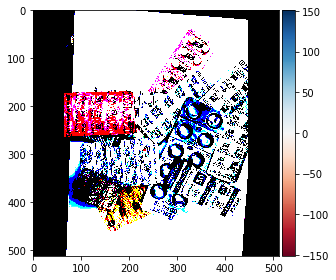

In [5]:
# Debug
print(molded_images.shape)
print(image_metas.shape)
print(windows)
# print(image_metas)  # [image_id(1), orginal_image_shape(3), image_shape(3), window(4), scale(1), num_classes(81)]
skimage.io.imshow(molded_images[0])

In [6]:
def get_anchors(config, image_shape):
        """Returns anchor pyramid for the given image size."""
        backbone_shapes = modellib.compute_backbone_shapes(config, image_shape)
        # Cache anchors and reuse if image shape is the same
        _anchor_cache = {}
        if not tuple(image_shape) in _anchor_cache:
            # Generate Anchors
            a = utils.generate_pyramid_anchors(
                config.RPN_ANCHOR_SCALES,
                config.RPN_ANCHOR_RATIOS,
                backbone_shapes,
                config.BACKBONE_STRIDES,
                config.RPN_ANCHOR_STRIDE)
            # Keep a copy of the latest anchors in pixel coordinates because
            # it's used in inspect_model notebooks.
            # TODO: Remove this after the notebook are refactored to not use it
            anchors = a
            # Normalize coordinates
            _anchor_cache[tuple(image_shape)] = utils.norm_boxes(a, image_shape[:2])
        return _anchor_cache[tuple(image_shape)]

In [7]:
image_shape = molded_images[0].shape
anchors = get_anchors(config, image_shape)
anchors = np.broadcast_to(anchors, (config.BATCH_SIZE,) + anchors.shape)

In [8]:
print(anchors.shape)

(1, 65472, 4)


In [9]:
# Load the model of the .pb format
graph_def = tf.GraphDef.FromString(open(DEFAULT_MODEL_PATH, 'rb').read())

with tf.Graph().as_default():            
    _ = tf.import_graph_def(graph_def, name='')
    session = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
    # Define the input and the output tensor
#     input_feed_dict = {"input_image:0": molded_images, 
#                        "input_image_meta:0": image_metas,
#                        "input_anchors:0": anchors}    
    input_feed_dict = {"input_image:0": molded_images, 
                       "input_image_meta:0": image_metas,
                       "input_anchors:0": anchors}
#     output_node = ["output_detections:0", "output_mrcnn_class:0", "output_mrcnn_bbox:0", 
#                    "output_mrcnn_mask:0", "output_rois:0", "output_rpn_class:0", "output_rpn_bbox:0"]
    mrcnn_output_list = session.run(["output_detections:0", "output_mrcnn_mask:0"], feed_dict=input_feed_dict)

In [10]:
detections = mrcnn_output_list[0]
mrcnn_mask = mrcnn_output_list[1]
print(detections.shape)
print(mrcnn_mask.shape)

(1, 100, 6)
(1, 100, 28, 28, 2)


In [11]:
# copied from "MaskRCNN.unmold_detections(self, ...):" at "mmrcnn/model.py"
def unmold_detections(detections, mrcnn_mask, original_image_shape,
                      image_shape, window):
    # How many detections do we have?
    # Detections array is padded with zeros. Find the first class_id == 0.
    zero_ix = np.where(detections[:, 4] == 0)[0]
    N = zero_ix[0] if zero_ix.shape[0] > 0 else detections.shape[0]

    # Extract boxes, class_ids, scores, and class-specific masks
    boxes = detections[:N, :4]
    class_ids = detections[:N, 4].astype(np.int32)
    scores = detections[:N, 5]
    masks = mrcnn_mask[np.arange(N), :, :, class_ids]

    # Translate normalized coordinates in the resized image to pixel
    # coordinates in the original image before resizing
    #print("original_image_shape: ",original_image_shape) #DEBUGGING
    #print("image_shape: ",image_shape) #DEBUGGING
    #print("window before norm: ",window) #DEBUGGING
    window = utils.norm_boxes(window, image_shape[:2])
    #print("window after norm: ",window) #DEBUGGING
    wy1, wx1, wy2, wx2 = window
    shift = np.array([wy1, wx1, wy1, wx1])
    wh = wy2 - wy1  # window height
    ww = wx2 - wx1  # window width
    scale = np.array([wh, ww, wh, ww])
    #print("scale: ",scale) #DEBUGGING
    # Convert boxes to normalized coordinates on the window
    boxes = np.divide(boxes - shift, scale) # ZERO DIVISION
    # Convert boxes to pixel coordinates on the original image
    boxes = utils.denorm_boxes(boxes, original_image_shape[:2])

    # Filter out detections with zero area. Happens in early training when
    # network weights are still random
    exclude_ix = np.where(
        (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1]) <= 0)[0]
    if exclude_ix.shape[0] > 0:
        boxes = np.delete(boxes, exclude_ix, axis=0)
        class_ids = np.delete(class_ids, exclude_ix, axis=0)
        scores = np.delete(scores, exclude_ix, axis=0)
        masks = np.delete(masks, exclude_ix, axis=0)
        N = class_ids.shape[0]

    # Resize masks to original image size and set boundary threshold.
    full_masks = []
    for i in range(N):
        # Convert neural network mask to full size mask
        full_mask = utils.unmold_mask(masks[i], boxes[i], original_image_shape)
        full_masks.append(full_mask)
    full_masks = np.stack(full_masks, axis=-1)\
        if full_masks else np.empty(masks.shape[1:3] + (0,))

    return boxes, class_ids, scores, full_masks

In [12]:
final_rois, final_class_ids, final_scores, final_masks =\
    unmold_detections(detections[0], mrcnn_mask[0], image.shape, molded_images[0].shape, windows[0])

In [13]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG',"drug"]

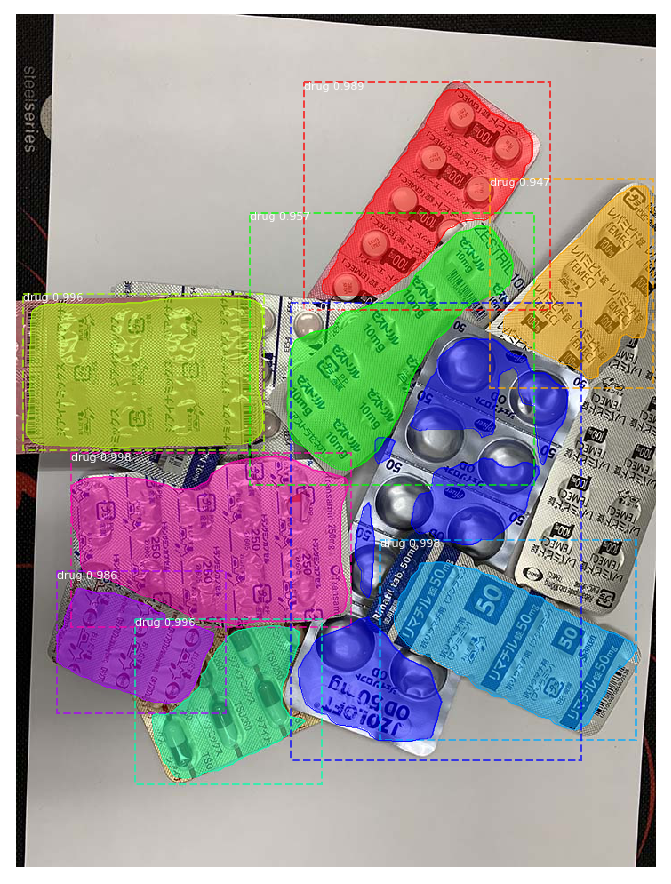

In [14]:
visualize.display_instances(image, final_rois, final_masks, final_class_ids, 
                                class_names, final_scores)

In [19]:
import cv2
net = cv2.dnn.readNetFromTensorflow(DEFAULT_MODEL_PATH, DEFAULT_TEXT_GRAPH);

error: OpenCV(4.1.2) /Users/travis/build/skvark/opencv-python/opencv/modules/dnn/src/tensorflow/tf_io.cpp:54: error: (-2:Unspecified error) FAILED: ReadProtoFromTextFile(param_file, param). Failed to parse GraphDef file: /Users/apple/Desktop/machine_learning/projects/Mobile_Mask_RCNN/logs/frozen_graph.pbtxt in function 'ReadTFNetParamsFromTextFileOrDie'


TypeError: join() argument must be str or bytes, not 'bool'

In [20]:
import PIL.Image

In [38]:
image = PIL.Image.open("../05_test.jpg")

In [42]:
img = np.asarray(image.convert('L'))
print(img)

[[136 136 136 ... 198 198 197]
 [137 137 137 ... 198 198 197]
 [137 137 137 ... 198 198 198]
 ...
 [194 194 193 ... 205 205 206]
 [195 195 194 ... 204 204 205]
 [195 195 195 ... 203 203 204]]


In [26]:
print(img*0)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [24]:
print(np.asarray(image).shape)

(720, 960, 3)


In [47]:
img_test = (img == 136).astype(np.uint8)
print(img_test)

[[1 1 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [48]:
import io
image_test = PIL.Image.fromarray(img_test)
output = io.BytesIO()
image_test.save(output, format='PNG')
print(output.getvalue())

b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03\xc0\x00\x00\x02\xd0\x08\x00\x00\x00\x00z\x1cFh\x00\x00\x08\xa3IDATx\x9c\xed\xdd\xdbz\x9b:\x10\x06P\xd4\xf7\x7f\xe7\xbd/\xda&M\x0c\x01\x8c\x0e3\xd2Z\x17m\xd2\xcf\xc1#\xe9\x1f\xe1:\xc6.e\xdb\xfe\xdb\x00\x00\x80\xab\xca\xe8\x02\x80\xb7\xfd\xda\x8a\x16\x86\xac~mN\xc2\x90\xd6/OBC^\xbf\xf4/\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xb1\x94\xd1\x05\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\

In [34]:
print(image_test)

<PIL.Image.Image image mode=1 size=960x720 at 0x162A4A518>
